# Manual Tuning

First the Zeigler-Nichols tuning method will be attempted. This is the most frequently cited although it is noted as being too aggressive for many applications. The "no overshoot" variant will be used here as the boiler is slow to cool in comparison to heating.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import parse
from manual_tuning_helper import load_silvia_response, load_silvia_responses

In [2]:
dataset_filenames = [
    "silvia_response_data_kp10ki0kd0_v01.json",
    "silvia_response_data_kp25ki0kd0_v01.json",
#     "silvia_response_data_kp40ki0kd0_v01.json",
    "silvia_response_data_kp50ki0kd0_v01.json",
    "silvia_response_data_kp100ki0kd0_v01.json",
#     "silvia_response_data_kp150ki0kd0_v01.json",
    "silvia_response_data_kp250ki0kd0_v01.json",
    "silvia_response_data_kp500ki0kd0_v01.json"
#     "silvia_response_data_kp35ki0kd50.json"
]

setpoint = 85  # degC

In [3]:
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])

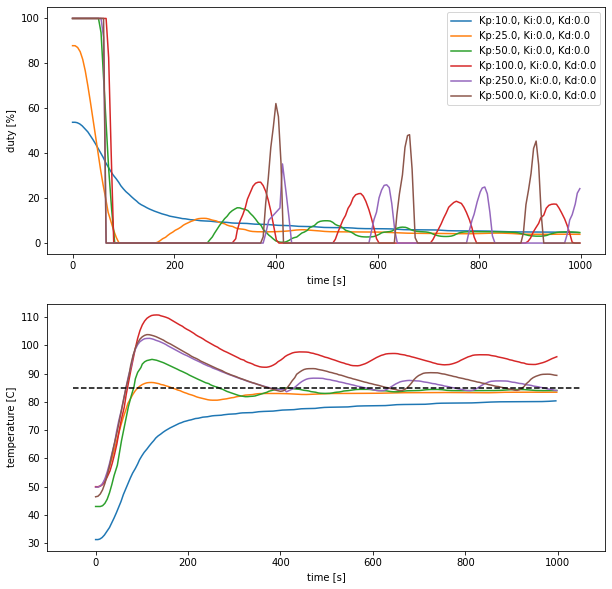

In [4]:
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

## Zoom in to look at the oscillations

(300.0, 1000.0, 80.0, 93.0)

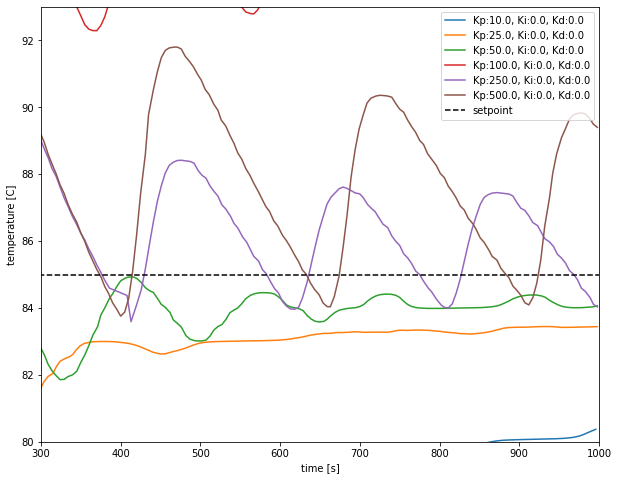

In [5]:
fig, ax_T = plt.subplots(figsize=(10, 8))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_T.legend()
ax_T.axis([300,1000, 80,93])

# Collect data for longer period
It is hard to see if oscillations will continue indefinetley recording for only 1000 seconds.

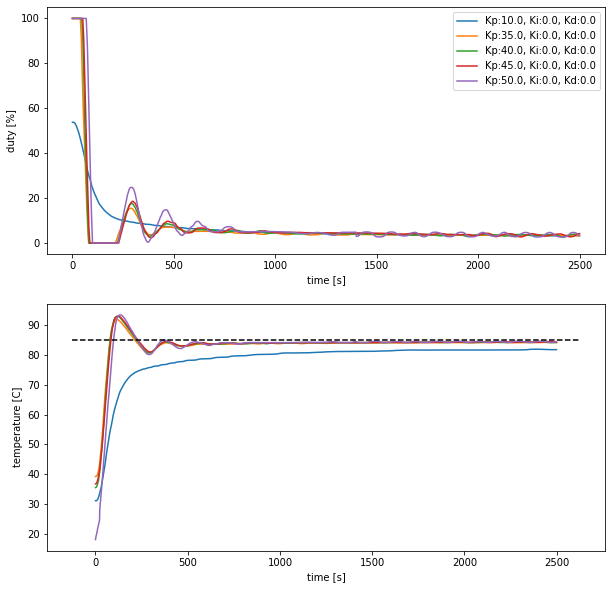

In [6]:
dataset_filenames = [
    "silvia_response_data_kp10ki0kd0_v01.json",
    "silvia_response_data_kp35ki0kd0_v02.json",
    "silvia_response_data_kp40ki0kd0_v02.json",
    "silvia_response_data_kp45ki0kd0_v02.json",
    "silvia_response_data_kp50ki0kd0_v02.json"
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 2500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

(1500.0, 2500.0, 81.0, 85.5)

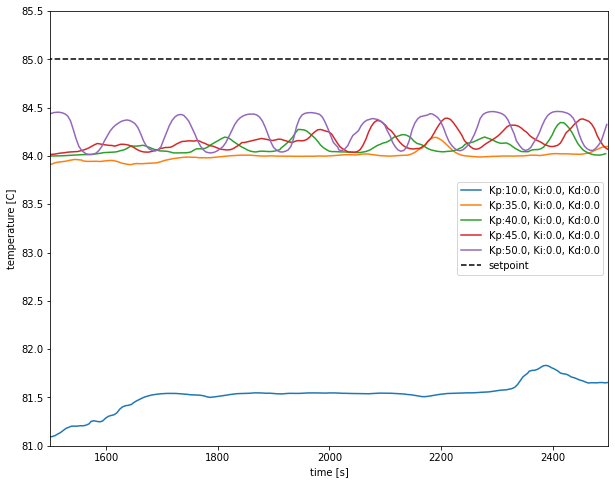

In [7]:
fig, ax_T = plt.subplots(figsize=(10, 8))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_T.legend()
ax_T.axis([1500,2500, 81,85.5])

It looks as if at Kp = 50 the oscillations become stable.

# Inspect oscillation frequency

In [8]:
t_start = 1500
t_end = 2500
data = load_silvia_response("silvia_response_data_kp50ki0kd0_v02.json", time=[0, t_end])

Resample data at fixed frequency

Text(0, 0.5, 'temperature [c]')

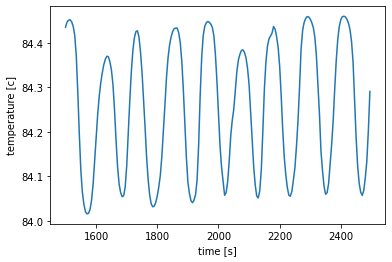

In [9]:
f_sample = 1 / 5  # Sample frequency [Hz]
t = np.arange(t_start, t_end, 1/f_sample)
T = np.interp(t, data["t"], data["T"])
plt.plot(t, T)
plt.xlabel("time [s]")
plt.ylabel("temperature [c]")

Text(0.5, 0, 'frequency [Hz]')

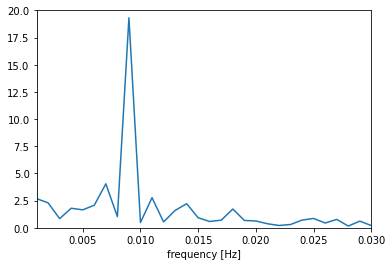

In [10]:
n = t.shape[-1]
sp = abs(np.fft.rfft(T))
# FFT is evaluated from -f_s/ 2 to f_s/2 where f_s is the sampling frequency
# FOr results in Hz the frequencies must be scaled back using the sampling frequency
freq = np.fft.rfftfreq(n) * f_sample
# Result is giving massive value at 0 Hz, ignore this
max_relevant = max(sp[1:])

fig, ax = plt.subplots()
ax.plot(freq, sp)
plt.xlim(0.001, 3 / 100)
plt.ylim(0, np.ceil(max_relevant))
ax.set_xlabel('frequency [Hz]')

Frequency at maximum amplitude

In [11]:
index_max = np.where(sp == max_relevant)
f_oscillation = freq[index_max][0]
"Oscillation frequency = {}Hz".format(f_oscillation)

'Oscillation frequency = 0.009Hz'

In [12]:
"Period = {:.2f}s".format(1/f_oscillation)

'Period = 111.11s'

Check on graph

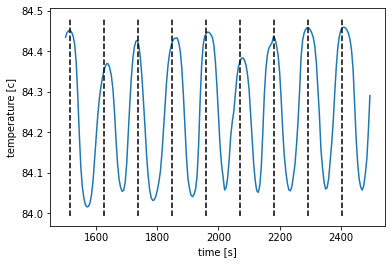

In [13]:
plt.plot(t, T)
plt.xlabel("time [s]")
plt.ylabel("temperature [c]")

index_first_peak_window_end = np.squeeze(np.where(t == 1550)[0])
index_first_peak = np.where(T[:index_first_peak_window_end] == np.max(T[:index_first_peak_window_end]))
n_peaks = 9
y_limits = plt.ylim()
for i_peak in range(n_peaks):
    t_peak = t[index_first_peak] + i_peak * 1/f_oscillation
    plt.plot([t_peak, t_peak], y_limits, '--', c='k')

Looks fairly good

## Ziegler-Nichols
Usinghthe Ziegler-Nichols tuning method ([wikipedia](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method#:~:text=The%20Ziegler%E2%80%93Nichols%20tuning%20(represented,PID%20loops%20best%20disturbance%20rejection.)), the values for Ki & Kd can be calculated as follows for a system with no desired overshoot:

| Control Type | $K_{p}$ | $T_{i}$ | $T_{d}$ | $K_{i}$ | $K_{d}$ |
| :-: | :-: |  :-: |  :-: |  :-: |  :-: |
| no overshoot | $K_{u}/5$ | $T_{u}/2$ | $T_{u}/3$ | $(2/5)K_{u}/T_{u}$ | $K_{u}T_{u}/15$ |

In [14]:
Ku = 50
Tu = 1 / f_oscillation

Kp = Ku / 5
Ti = Tu / 2
Td = Tu / 3
Ki = Kp/ Ti
Kd = Kp * Td

print("Gains: [{0:.4f}, {1:.4f}, {2:.4f}]\nPeriods: [N/A, {0:.4f}, {1:.4f}]".format(Kp, Ki, Kd, Ti, Td))

Gains: [10.0000, 0.1800, 370.3704]
Periods: [N/A, 10.0000, 0.1800]


## Test gains

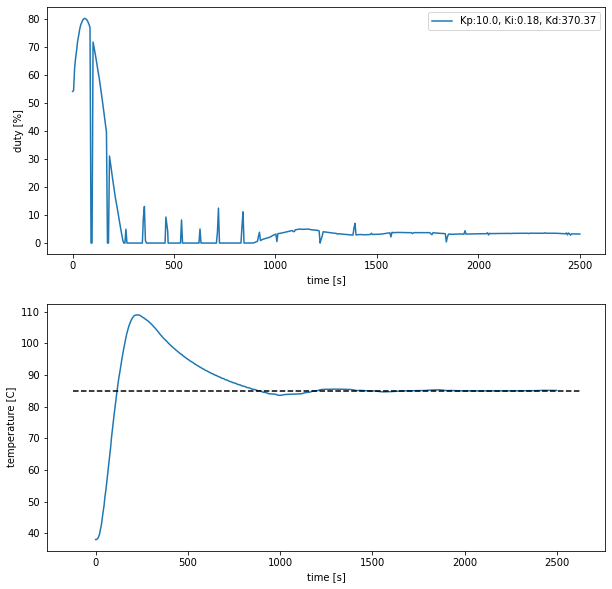

In [15]:
dataset = load_silvia_response("silvia_response_data_kp10ki0.18kd370.37_v01.json", time=[0, 2500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
ax_u.plot(dataset["t"], dataset["u"], label=label)
ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

This was supposed to be "no overshoot" which clearly hasn't worked out. Also the control input is a bit discontinuous.


The controller was still somewhat oscillating at Kp = 40 so try that (albeit close) to see the difference.

Text(0, 0.5, 'temperature [c]')

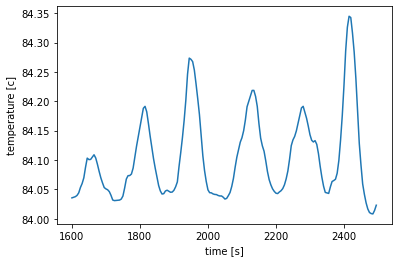

In [16]:
t_start = 1600
t_end = 2500
data = load_silvia_response("silvia_response_data_kp40ki0kd0_v02.json", time=[0, t_end])
# Resample
f_sample = 1 / 5  # Sample frequency [Hz]
t = np.arange(t_start, t_end, 1/f_sample)
T = np.interp(t, data["t"], data["T"])
plt.plot(t, T)
plt.xlabel("time [s]")
plt.ylabel("temperature [c]")

Text(0.5, 0, 'frequency [Hz]')

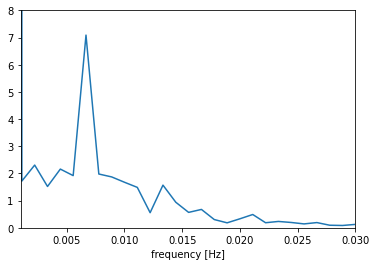

In [17]:
# Look at FFT
n = t.shape[-1]
sp = abs(np.fft.rfft(T))
# FFT is evaluated from -f_s/ 2 to f_s/2 where f_s is the sampling frequency
# FOr results in Hz the frequencies must be scaled back using the sampling frequency
freq = np.fft.rfftfreq(n) * f_sample
# Result is giving massive value at 0 Hz, ignore this
max_relevant = max(sp[1:])

fig, ax = plt.subplots()
ax.plot(freq, sp)
plt.xlim(0.001, 3 / 100)
plt.ylim(0, np.ceil(max_relevant))
ax.set_xlabel('frequency [Hz]')

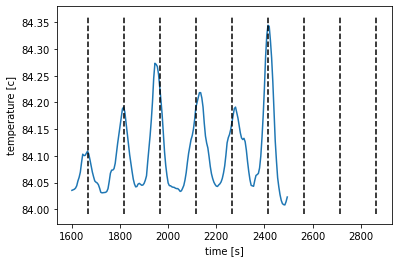

In [18]:
index_max = np.where(sp == max_relevant)
f_oscillation = freq[index_max][0]
"Oscillation frequency = {:0.6f}Hz".format(f_oscillation)
# Check on graph
plt.plot(t, T)
plt.xlabel("time [s]")
plt.ylabel("temperature [c]")

index_first_peak_window_end = np.squeeze(np.where(t == 1700)[0])
index_first_peak = np.where(T[:index_first_peak_window_end] == np.max(T[:index_first_peak_window_end]))
n_peaks = 9
y_limits = plt.ylim()
for i_peak in range(n_peaks):
    t_peak = t[index_first_peak] + i_peak * 1/f_oscillation
    plt.plot([t_peak, t_peak], y_limits, '--', c='k')

In [19]:
Ku = 40
Tu = 1 / f_oscillation

Kp = Ku / 5
Ti = Tu / 2
Td = Tu / 3
Ki = Kp/ Ti
Kd = Kp * Td

print("Gains: [{0:.4f}, {1:.4f}, {2:.4f}]\nPeriods: [N/A, {0:.4f}, {1:.4f}]".format(Kp, Ki, Kd, Ti, Td))

Gains: [8.0000, 0.1067, 400.0000]
Periods: [N/A, 8.0000, 0.1067]


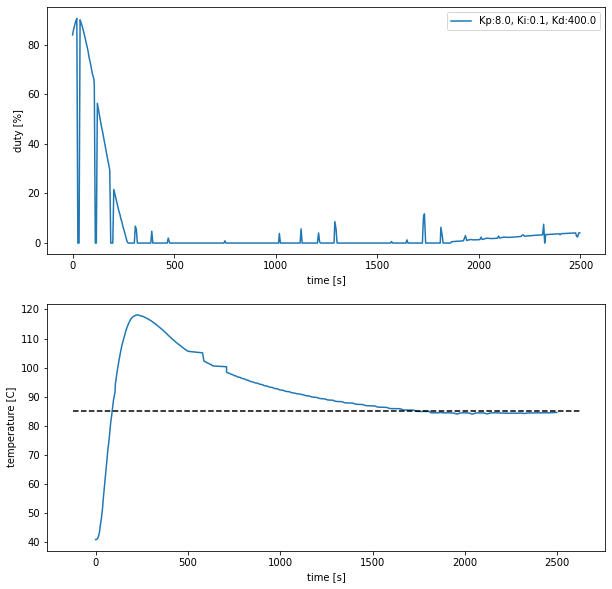

In [20]:
dataset = load_silvia_response("silvia_response_data_kp8ki0.1kd400_v01.json", time=[0, 2500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
ax_u.plot(dataset["t"], dataset["u"], label=label)
ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

The results are no better, a different approach is requered.

## Skogestad IMC tuning Method
[reference](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.623.275&rep=rep1&type=pdf)

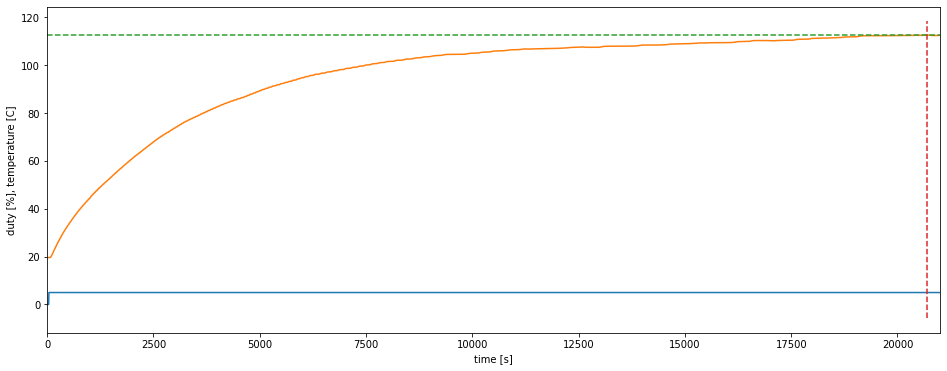

In [21]:
dataset = load_silvia_response("silvia_response_data_d5.json", time=[0, -1], input_type="step")
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dataset["t"], dataset["u"])
ax.plot(dataset["t"], dataset["T"])
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 21000)
T_ss = np.max(dataset["T"])
ax.plot(ax.get_xlim(), [T_ss, T_ss], '--')
t_ss = dataset["t"][np.argmax(dataset["T"] - T_ss >= 0)]
ax.plot([t_ss, t_ss], ax.get_ylim(), '--')

Response looks predominantlt first order.  

Look closely at the start to identify initial delay time

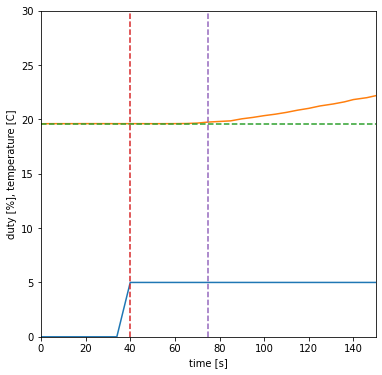

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(dataset["t"], dataset["u"])
ax.plot(dataset["t"], dataset["T"])
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 150)
ax.set_ylim(0, 30)
T_0 = np.min(dataset["T"])
ax.plot(ax.get_xlim(), [T_0, T_0], '--')
t_step = dataset["t"][np.argmax(dataset["u"] > 2)]
t_react = dataset["t"][np.argmax(dataset["T"] - dataset["T"][0] > 0.1)]
ax.plot([t_step, t_step], ax.get_ylim(), '--')
ax.plot([t_react, t_react], ax.get_ylim(), '--')

In [23]:
print("Steady state temperature: {:.1f} degC".format(T_ss))
print("Time to reach steady state temperature: {} s".format(t_ss - t_step))

Steady state temperature: 112.6 degC
Time to reach steady state temperature: 20650 s


Calculate tuning paramaters

In [24]:
u_step = dataset["u"][np.argmax(dataset["u"] > 0)]
k = (T_ss - T_0) / u_step
theta = t_react - t_step
tau_1 = dataset["t"][ np.where(dataset["T"] >= 0.63 * T_ss)[0][0] ]
print("[k, theta, tau_1] = [{:.1f}, {}, {:.1f}]".format(k, theta, tau_1))

[k, theta, tau_1] = [18.6, 35, 2752.0]


Calculate gains

In [25]:
# Need to tune this
tau_c = theta
K_c_cascade = tau_1 / (k * (tau_c + theta))
k_dash = k / tau_1
tau_I_cascade = min(tau_1, 4 / (k_dash * K_c_cascade))
tau_D_cascade = 0
print("[K_c, K', tau_I, tau_D] = [{:.1f}, {:.5f}, {:.1f}, {}]".format(K_c_cascade, k_dash, tau_I_cascade, tau_D_cascade))

[K_c, K', tau_I, tau_D] = [2.1, 0.00676, 280.0, 0]


In [26]:
# Ideal PID
K_c = K_c_cascade * (1 + tau_D_cascade / tau_I_cascade)
tau_I = tau_I_cascade * (1 + tau_D_cascade / tau_I_cascade)
tau_D = tau_D_cascade / (1 + tau_D_cascade / tau_I_cascade)

Kp = K_c
Ki = Kp/ tau_I
Kd = Kp * tau_D

print("Gains: [{0:.4f}, {1:.4f}, {2:.4f}]".format(Kp, Ki, Kd))

Gains: [2.1130, 0.0075, 0.0000]


Text(0.5, 1.0, 'Kp:2.1, Ki:0.008, Kd:0.0')

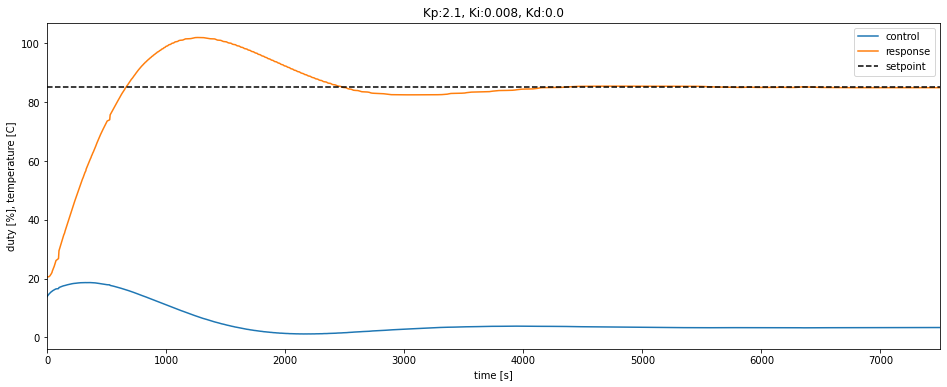

In [27]:
dataset = load_silvia_response("silvia_response_data_kp2.1ki0.008kd0_v01.json", time=[0, -1])
label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dataset["t"], dataset["u"], label="control")
ax.plot(dataset["t"], dataset["T"], label="response")
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 7500)
ax.plot(ax.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax.legend()
ax.set_title(label)

This is a very slow response. Next look at measuring initial slope with higher step input.

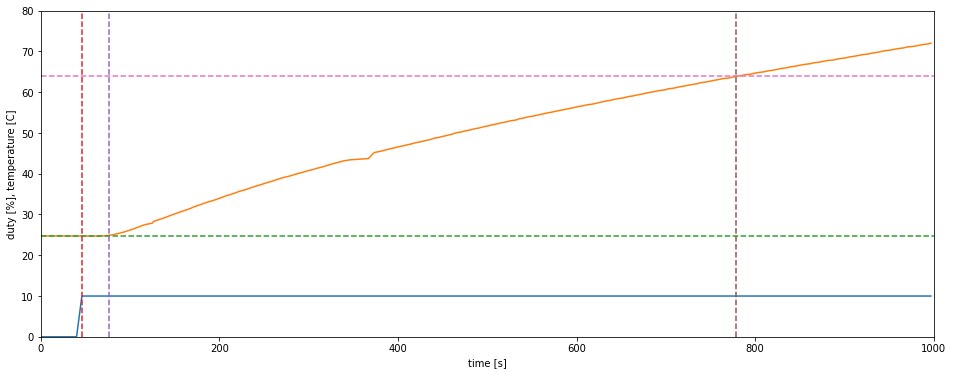

In [28]:
dataset = load_silvia_response("silvia_response_data_d10.json", time=[0, 1000], input_type="step")
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dataset["t"], dataset["u"])
ax.plot(dataset["t"], dataset["T"])
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 80)

T_0 = np.min(dataset["T"])
ax.plot(ax.get_xlim(), [T_0, T_0], '--')
t_step = dataset["t"][np.argmax(dataset["u"] > 2)]
t_react = dataset["t"][np.argmax(dataset["T"] - dataset["T"][0] > 0.1)]
ax.plot([t_step, t_step], ax.get_ylim(), '--')
ax.plot([t_react, t_react], ax.get_ylim(), '--')

dx = 700
index_2 = np.argmax(dataset["t"] >= t_react + dx)
t_2 = dataset["t"][index_2]
T_2 = dataset["T"][index_2]
ax.plot([t_2, t_2], ax.get_ylim(), '--')
ax.plot(ax.get_xlim(), [T_2, T_2], '--')

In [29]:
u_step = dataset["u"][np.argmax(dataset["u"] > 0)]
k_dash = (T_2 - T_0) / (t_2 - t_react) / u_step
theta = t_react - t_step

# Try tau_c = theta
# tau_c = theta
# K_c_cascade = 1 / (k_dash * (tau_c + theta))
# tau_I_cascade = 4 / (k_dash * K_c_cascade)

# Tune for fast response
K_c_cascade = 0.5 / (k_dash * theta)
tau_I_cascade = 8 * theta

# tau_2 = Time constant of sensor at 0fpm air velocity
# Pg. 32:
# http://folk.ntnu.no/skoge/plantwide/plantwide-course-brasil-july2011/pdf-02jul2011/plantwide6_tuning.pdf
tau_D_cascade = 35  
print("[K_c, K', tau_I, tau_D] = [{:.1f}, {:.5f}, {:.1f}, {}]".format(K_c_cascade, k_dash, tau_I_cascade, tau_D_cascade))

[K_c, K', tau_I, tau_D] = [3.0, 0.00557, 240.0, 35]


In [30]:
# Ideal PID
K_c = K_c_cascade * (1 + tau_D_cascade / tau_I_cascade)
tau_I = tau_I_cascade * (1 + tau_D_cascade / tau_I_cascade)
tau_D = tau_D_cascade / (1 + tau_D_cascade / tau_I_cascade)

Kp = K_c
Ki = Kp/ tau_I
Kd = Kp * tau_D

print("Gains: [{0:.4f}, {1:.4f}, {2:.4f}]".format(Kp, Ki, Kd))

Gains: [3.4275, 0.0125, 104.6947]


Text(0.5, 1.0, 'Kp:3.4, Ki:0.012, Kd:105.0')

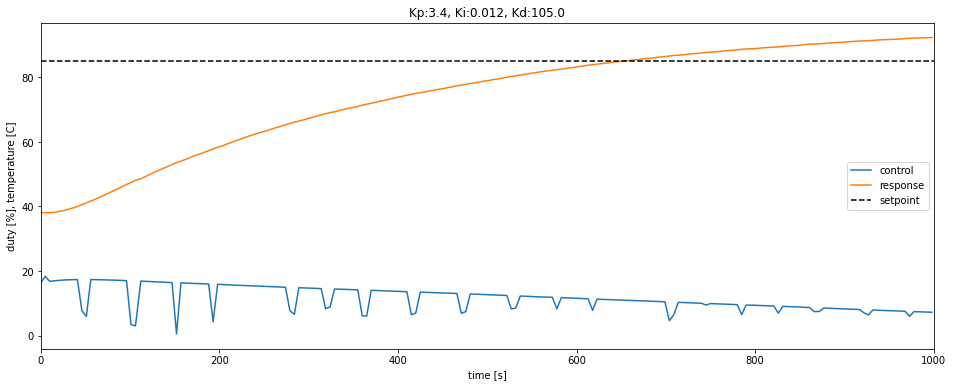

In [31]:
dataset = load_silvia_response("silvia_response_data_kp3.4ki0.012kd105_v01.json", time=[0, 1000])
label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dataset["t"], dataset["u"], label="control")
ax.plot(dataset["t"], dataset["T"], label="response")
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 1000)
ax.plot(ax.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax.legend()
ax.set_title(label)

Rubbish.....must be doing something wrong?

## Manual Tuning
Attempt tuning manually

### Add Derivative Gain

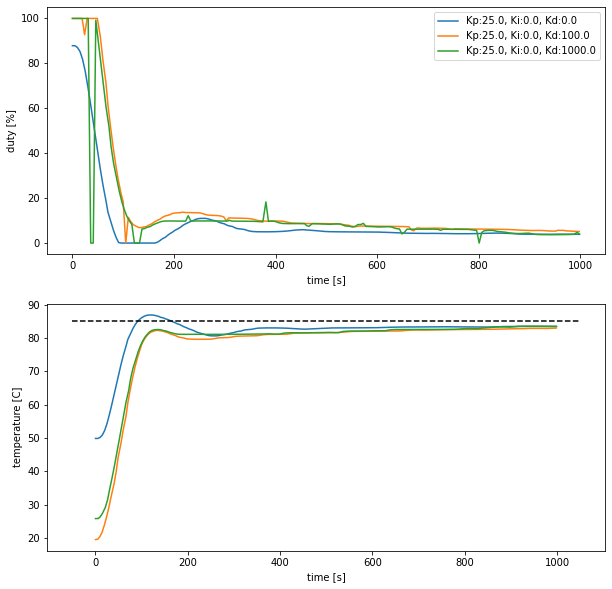

In [32]:
dataset_filenames = [
#     "silvia_response_data_kp40ki0kd0_v01.json",
#     "silvia_response_data_kp40ki0kd1_v01.json",
#     "silvia_response_data_kp40ki0kd10_v01.json",
#     "silvia_response_data_kp40ki0kd100_v01.json",
#     "silvia_response_data_kp35ki0kd50_v01.json",
    "silvia_response_data_kp25ki0kd0_v01.json",
    "silvia_response_data_kp25ki0kd100_v01.json",
    "silvia_response_data_kp25ki0kd1000_v01.json",
#     "silvia_response_data_kp20ki0kd100_v01.json",
#     "silvia_response_data_kp15ki0kd100_v01.json",
#     "silvia_response_data_kp15ki0kd100_v01.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

(0.0, 800.0, 75.0, 95.0)

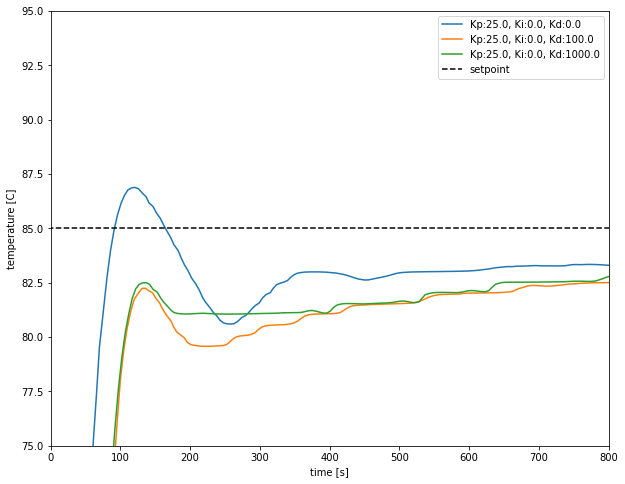

In [33]:
fig, ax_T = plt.subplots(figsize=(10, 8))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_T.legend()
ax_T.axis([0,800, 75,95])

### Add Integral Gain

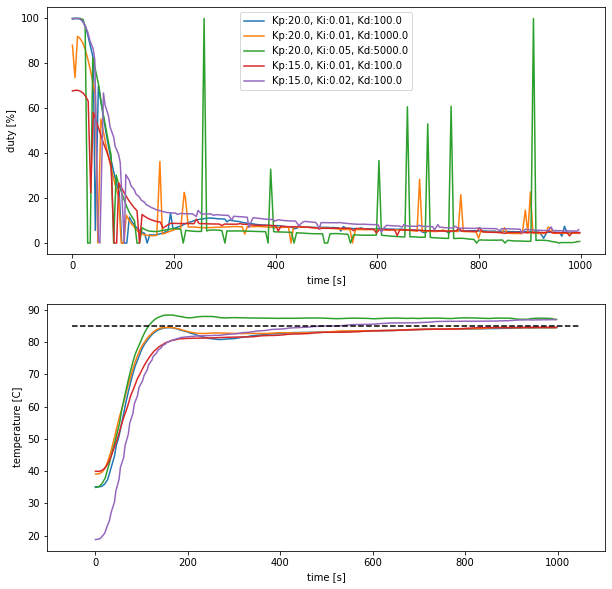

In [34]:
dataset_filenames = [
    "silvia_response_data_kp20ki0.01kd100_v01.json",
    "silvia_response_data_kp20ki0.01kd1000_v01.json",
    "silvia_response_data_kp20ki0.05kd5000_v01.json",
#     "silvia_response_data_kp20ki1kd1000_v01.json",
#     "silvia_response_data_kp18ki0.02kd5000_v01.json",
#     "silvia_response_data_kp16ki0.01kd500_v01.json",
#     "silvia_response_data_kp8ki0.1kd400_v01.json"
#     "silvia_response_data_kp17ki0.02kd500_v01.json",
#     "silvia_response_data_kp25ki0.001kd5000_v01.json",
#     "silvia_response_data_kp20ki0.01kd5000_v01.json",
    "silvia_response_data_kp15ki0.01kd100_v01.json",
    "silvia_response_data_kp15ki0.02kd100_v01.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()

(0.0, 1000.0, 80.0, 90.0)

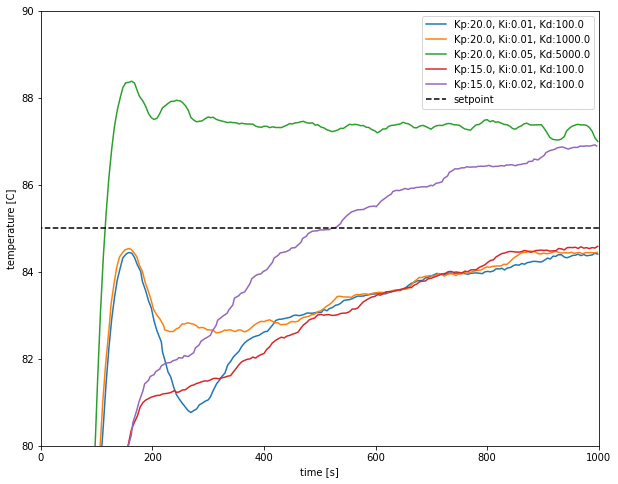

In [35]:
fig, ax_T = plt.subplots(figsize=(10, 8))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_T.legend()
ax_T.axis([0,1000, 80,90])

The integral gain is causing spikes in the control input when comnined with high derivative gain.

Text(0.5, 1.0, 'Kp:15.0, Ki:0.01, Kd:100.0')

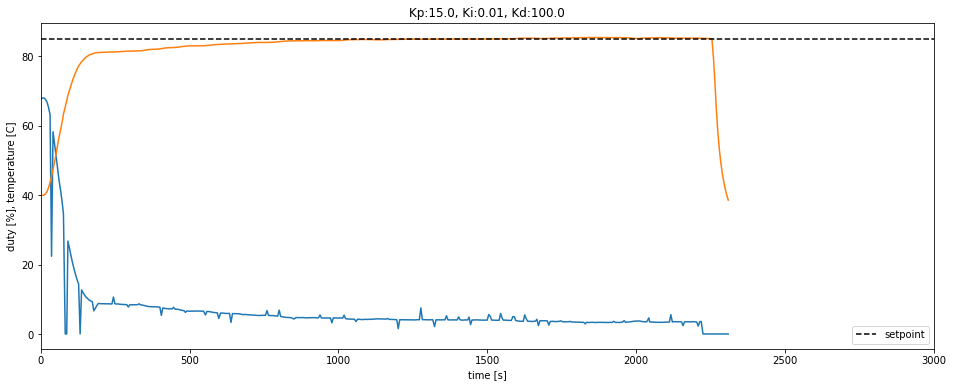

In [36]:
dataset = load_silvia_response("silvia_response_data_kp15ki0.01kd100_v01.json", time=[0, 3000])
label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dataset["t"], dataset["u"])
ax.plot(dataset["t"], dataset["T"])
ax.set_xlabel('time [s]')
ax.set_ylabel('duty [%], temperature [C]')
ax.set_xlim(0, 3000)
ax.plot(ax.get_xlim(), [setpoint, setpoint], '--', c='k', label="setpoint")
ax.legend()
ax.set_title(label)

## PID without a PHD method
https://www.wescottdesign.com/articles/pid/pidWithoutAPhd.pdf

### Set derivative gain
Start with Kp low enough so there is no oscillation.
Lets choose Kp = 15

Start with 100 times derivative gain
Kd = 1500

It did not oscillate so increase:
Kd = 7500

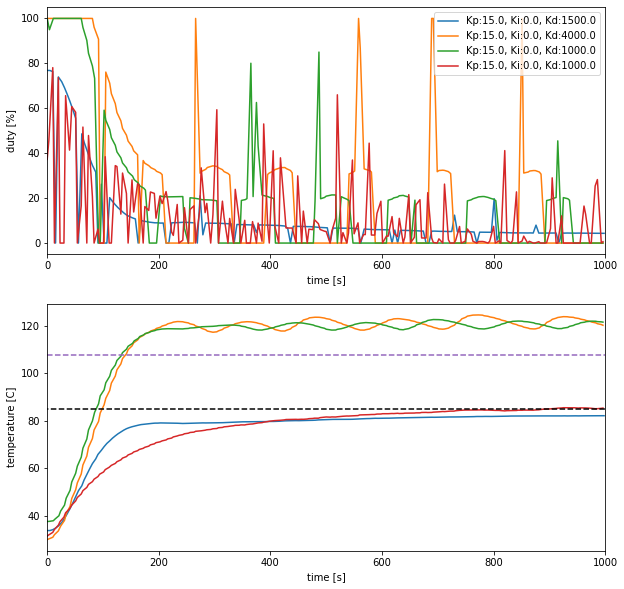

In [37]:
dataset_filenames = [
    "silvia_response_data_kp15ki0kd1500_v01.json",
#     "silvia_response_data_kp15ki0kd7500_v01.json",
#     "silvia_response_data_kp15ki0kd5000_v02.json",
    "silvia_response_data_kp15ki0kd4000_v01.json",
#     "silvia_response_data_kp15ki0kd3500_v01.json",
#     "silvia_response_data_kp15ki0kd3000_v01.json",
#     "silvia_response_data_kp15ki0kd3000_v02.json",
    "silvia_response_data_kp15ki0kd1000_v01.json",
    "silvia_response_data_kp15ki0kd1000_v11.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1000)
ax_T.set_xlim(0, 1000)

# 50% overshoot from 40degC
T_overshoot = (setpoint - 40) / 2 + setpoint
ax_T.plot(ax_T.get_xlim(), [T_overshoot, T_overshoot], '--')

The response starts to overshoot by greater then 50% at about Kd=4000.
The instructions say to now back off by a factor of 2 or 4.
Due to the oscillations in input signal increasing more with derivative gain I will back off by a factor of 4 to Kd=1000.

(0.0, 1000.0)

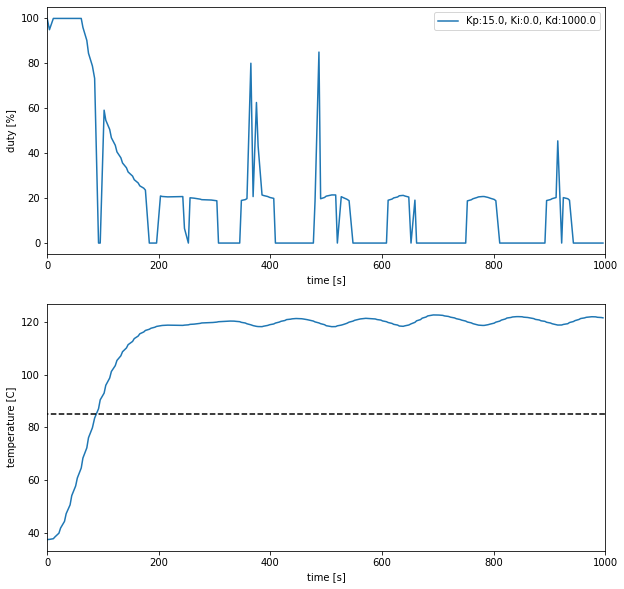

In [38]:
dataset_filenames = [
    "silvia_response_data_kp15ki0kd1000_v01.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1000)
ax_T.set_xlim(0, 1000)

This is not behaving as expected


## Try proportional gain on measurement
http://brettbeauregard.com/blog/2017/06/introducing-proportional-on-measurement/

(0.0, 1000.0)

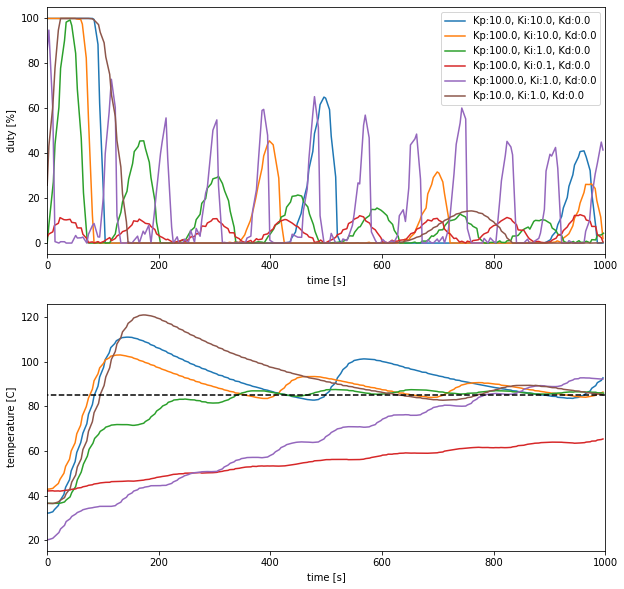

In [39]:
dataset_filenames = [
    "silvia_response_data_kp10ki10kd0_v21.json",
    "silvia_response_data_kp100ki10kd0_v21.json",
    "silvia_response_data_kp100ki1kd0_v21.json",
    "silvia_response_data_kp100ki0.1kd0_v21.json",
    "silvia_response_data_kp1000ki1kd0_v21.json",
    "silvia_response_data_kp10ki1kd0_v21.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1000)
ax_T.set_xlim(0, 1000)

## Change PID params 
* Decrease PID update frequency to 2Hz (from 5Hz)
* Reduce temperature smoothing (0.5 from 0.8)

### Back to Derivative Gain
Start again with "PID without a PHD"

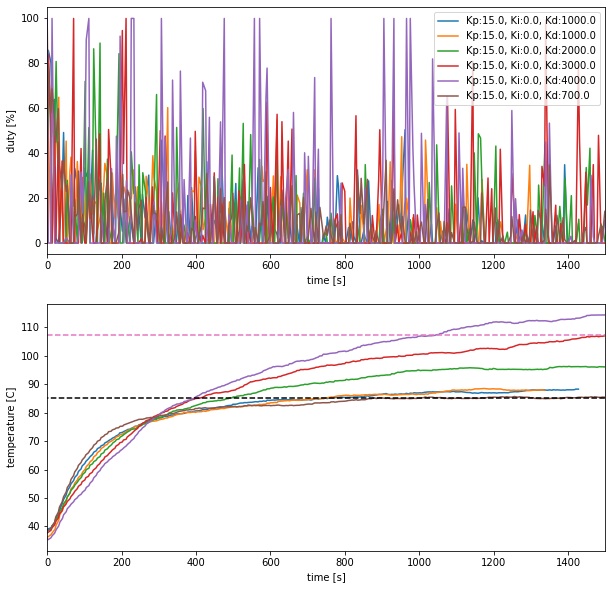

In [40]:
dataset_filenames = [
#     "silvia_response_data_kp15ki0kd1000_v01.json",
    "silvia_response_data_kp15ki0kd1000_v31.json",
    "silvia_response_data_kp15ki0kd1000_v32.json",
    "silvia_response_data_kp15ki0kd2000_v31.json",
    "silvia_response_data_kp15ki0kd3000_v31.json",
    "silvia_response_data_kp15ki0kd4000_v31.json",
    "silvia_response_data_kp15ki0kd700_v31.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1500)
ax_T.set_xlim(0, 1500)

# 50% overshoot from 40degC
T_overshoot = (setpoint - 40) / 2 + setpoint
ax_T.plot(ax_T.get_xlim(), [T_overshoot, T_overshoot], '--')

Looks like 50% overshoot will occur at about kd = 2800. Backing this off by a factor of 4 gives kd = 700.

The input signals are all extremely noisy though. Need to try much lower value.

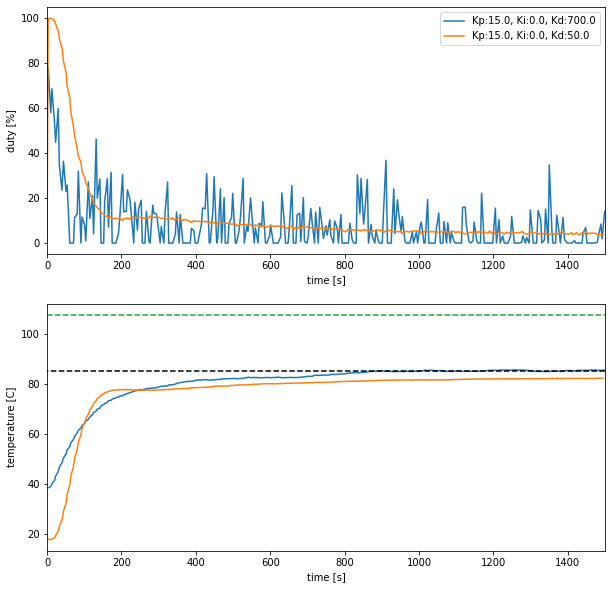

In [41]:
dataset_filenames = [
    "silvia_response_data_kp15ki0kd700_v31.json",
    "silvia_response_data_kp15ki0kd50_v41.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1500)
ax_T.set_xlim(0, 1500)

# 50% overshoot from 40degC
T_overshoot = (setpoint - 40) / 2 + setpoint
ax_T.plot(ax_T.get_xlim(), [T_overshoot, T_overshoot], '--')

This is much less noisy at kd = 50 and the response looks better.

### Proportional gain
Start with 1/100 derivative gain, therefore kp = 7. We can already see this has a sluggish response so lets increase by 10 to kp = 70.

(70.0, 120.0)

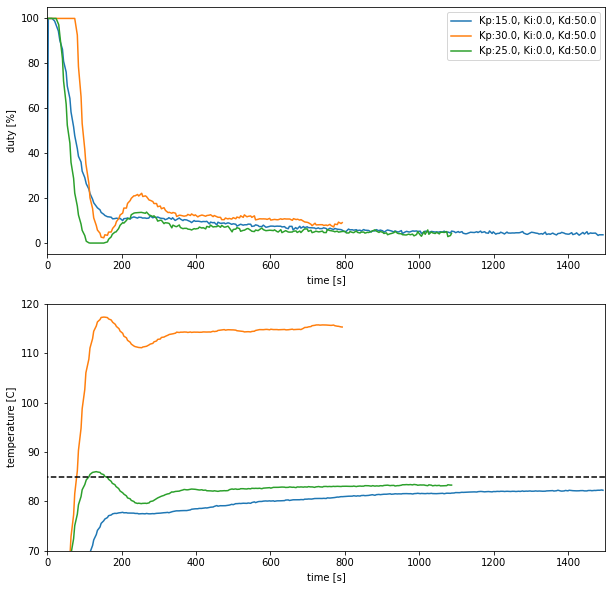

In [42]:
dataset_filenames = [
    "silvia_response_data_kp15ki0kd50_v41.json",
    "silvia_response_data_kp30ki0kd50_v41.json",
    "silvia_response_data_kp25ki0kd50_v41.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 1500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 1500)
ax_T.set_xlim(0, 1500)
ax_T.set_ylim(70, 120)

Excessive overshoot at kp = 30. Backing off by half gives us the first measurement of kp = 15.

### Integral Gain
Set integral gain the same proportioj below kp as kd is above, so ki = 4.5. Likely this will be a bit high but lets see.

(75.0, 90.0)

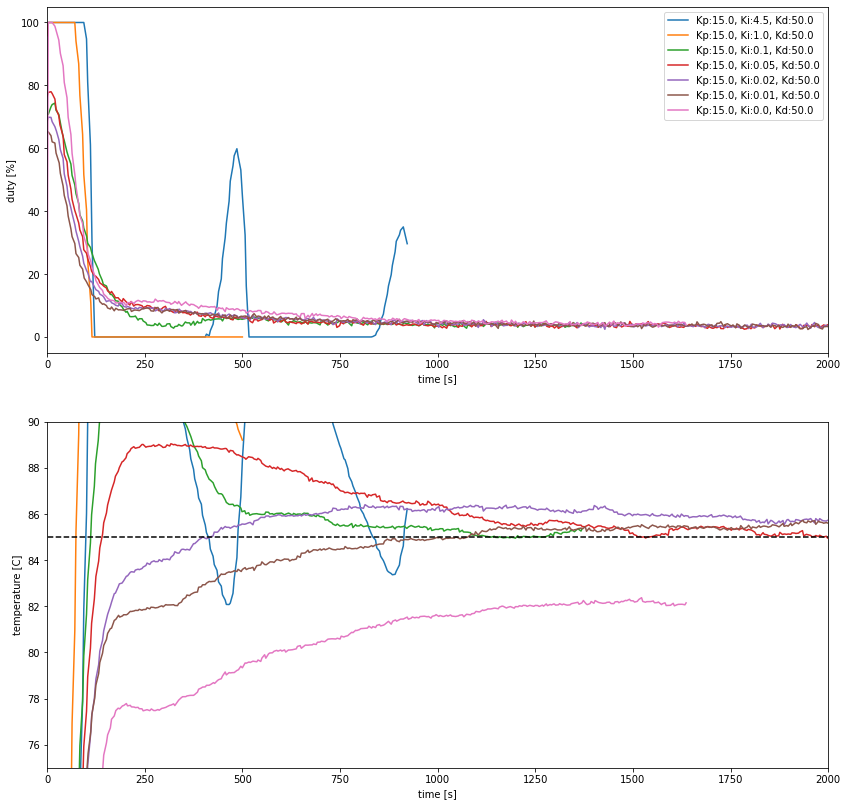

In [43]:
dataset_filenames = [
    "silvia_response_data_kp15ki4.5kd50_v41.json",
    "silvia_response_data_kp15ki1kd50_v41.json",
    "silvia_response_data_kp15ki0.1kd50_v41.json",
    "silvia_response_data_kp15ki0.05kd50_v41.json",
    "silvia_response_data_kp15ki0.02kd50_v41.json",
    "silvia_response_data_kp15ki0.01kd50_v41.json",
    "silvia_response_data_kp15ki0kd50_v41.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 2000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 2000)
ax_T.set_xlim(0, 2000)
ax_T.set_ylim(75, 90)

Try adjusting the proportional gain slightly

(80.0, 90.0)

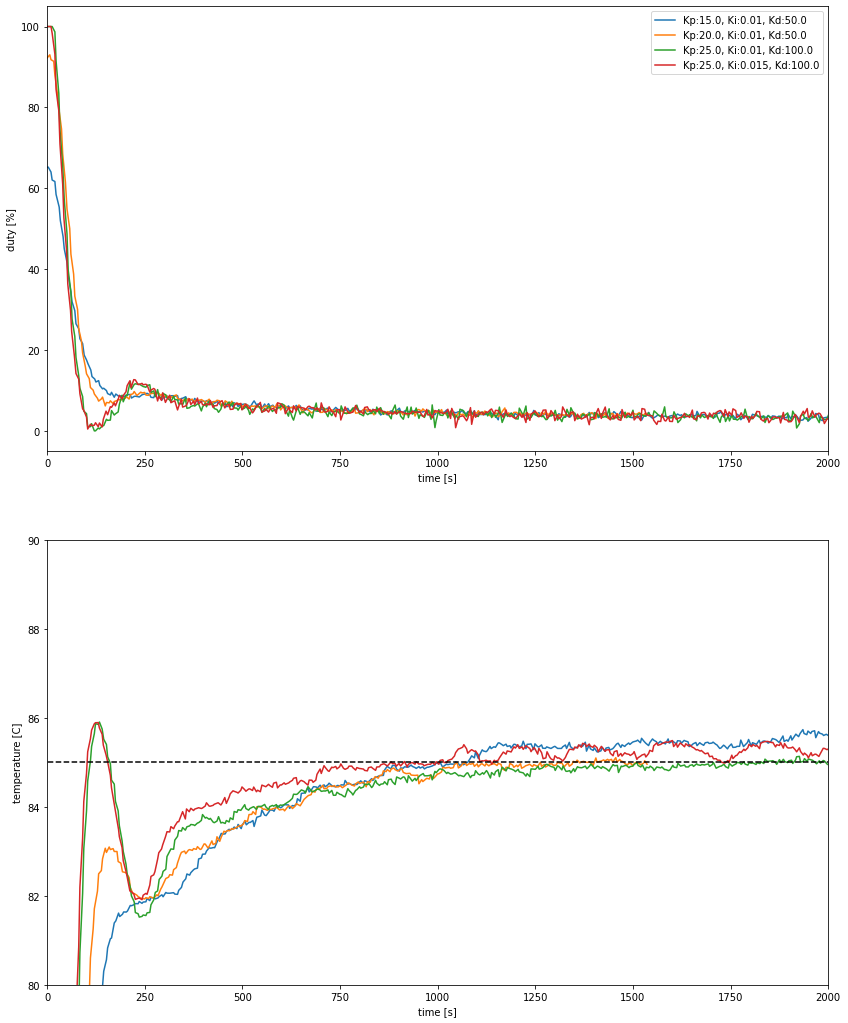

In [49]:
dataset_filenames = [
    "silvia_response_data_kp15ki0.01kd50_v41.json",
#     "silvia_response_data_kp18ki0.01kd50_v41.json",
    "silvia_response_data_kp20ki0.01kd50_v41.json",
#     "silvia_response_data_kp20ki0.02kd50_v41.json",
#     "silvia_response_data_kp20ki0.03kd50_v42.json",
#     "silvia_response_data_kp18ki0.01kd75_v41.json",
    "silvia_response_data_kp25ki0.01kd100_v41.json",
#     "silvia_response_data_kp30ki0.01kd150_v41.json",
#     "silvia_response_data_kp25ki0.015kd100_v41.json",
#     "silvia_response_data_kp35ki0.015kd200_v41.json",
    "silvia_response_data_kp20ki0.01kd100_v41.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 2000])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(14, 18))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [setpoint, setpoint], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 2000)
ax_T.set_xlim(0, 2000)
ax_T.set_ylim(80, 90)

The results look best from:
kp = 25, ki = 0.01, kd = 100

Lets check for robustness over some different starting temperatures and setpoints.

(30.0, 100.0)

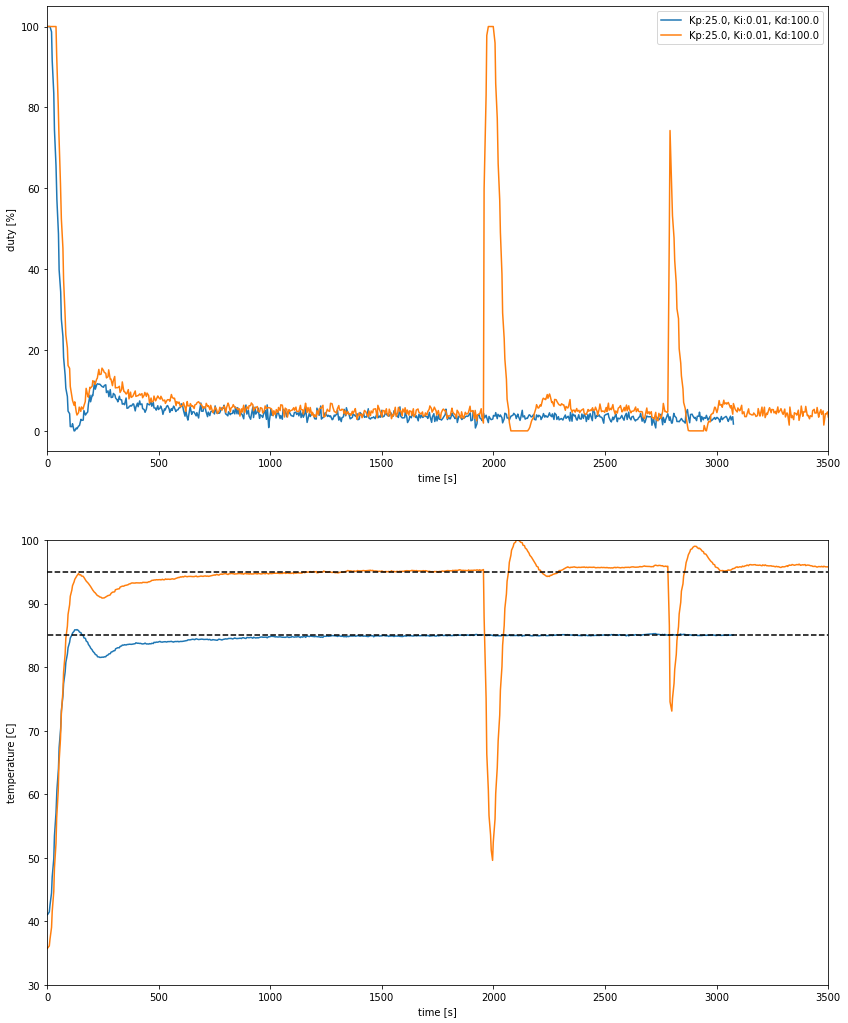

In [55]:
dataset_filenames = [
    "silvia_response_data_kp25ki0.01kd100_v41.json",
    "silvia_response_data_kp25ki0.01kd100_v42.json",
]
datasets = load_silvia_responses(dataset_filenames, time=[0, 3500])
fig, [ax_u, ax_T] = plt.subplots(nrows=2, ncols=1, figsize=(14, 18))
for dataset in datasets:
    label = "Kp:{0}, Ki:{1}, Kd:{2}".format(dataset["K"][0], dataset["K"][1], dataset["K"][2])
    ax_u.plot(dataset["t"], dataset["u"], label=label)
    ax_T.plot(dataset["t"], dataset["T"], label=label)
ax_T.plot(ax_T.get_xlim(), [85, 85], '--', c='k')
ax_T.plot(ax_T.get_xlim(), [95, 95], '--', c='k')
ax_u.set_xlabel('time [s]')
ax_u.set_ylabel('duty [%]')
ax_T.set_xlabel('time [s]')
ax_T.set_ylabel('temperature [C]')
ax_u.legend()
ax_u.set_xlim(0, 3500)
ax_T.set_xlim(0, 3500)
ax_T.set_ylim(30, 100)